In [1]:
from __future__ import print_function
import argparse
from tqdm import tqdm
import os
import pandas as pd
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import torchvision
from torchvision import transforms
from glob import glob
from model import GTSRBnet
import utils

In [2]:
model_file = '/home/stringlab/Desktop/DLCV_midterm_project/trained_models/model_49.pth'
test_dir = '/home/stringlab/Desktop/DLCV_midterm_project/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images'
output_file = open("pred.csv", "w")
state_dict = torch.load(model_file)
model = GTSRBnet(n_classes=43)
model.load_state_dict(state_dict)
model.eval();

In [3]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize([212, 256]),
    transforms.ToTensor()
])

output_file.write("Filename,ClassId\n")

for f in tqdm(sorted(glob(os.path.join(test_dir, "*.ppm")))):
    output = torch.zeros([1, 43], dtype=torch.float32)
    with torch.no_grad():
        data = transform(utils.pil_loader(f))
        data = data.view(1, data.size(0), data.size(1), data.size(2))
        data = Variable(data)
        output = output.add(model(data))
        pred = output.data.max(1, keepdim=True)[1]
        file_id = f[0:5]
        output_file.write("%s,%d\n" % (file_id, pred))
        
output_file.close()

100%|██████████| 12630/12630 [04:10<00:00, 50.34it/s]


In [4]:
# Calculate test accuracy
gt_file = '/home/stringlab/Desktop/DLCV_midterm_project/GTSRB_Final_Test_GT/GT-final_test.csv'
gt = pd.read_csv(gt_file, sep=';')
pred_file = '/home/stringlab/Desktop/DLCV_midterm_project/pred.csv'
pred = pd.read_csv(pred_file, sep=',')

In [5]:
print("Accuracy: ", (gt['ClassId']==pred['ClassId']).sum()/len(gt)*100, "%")

Accuracy:  98.40063341250989 %


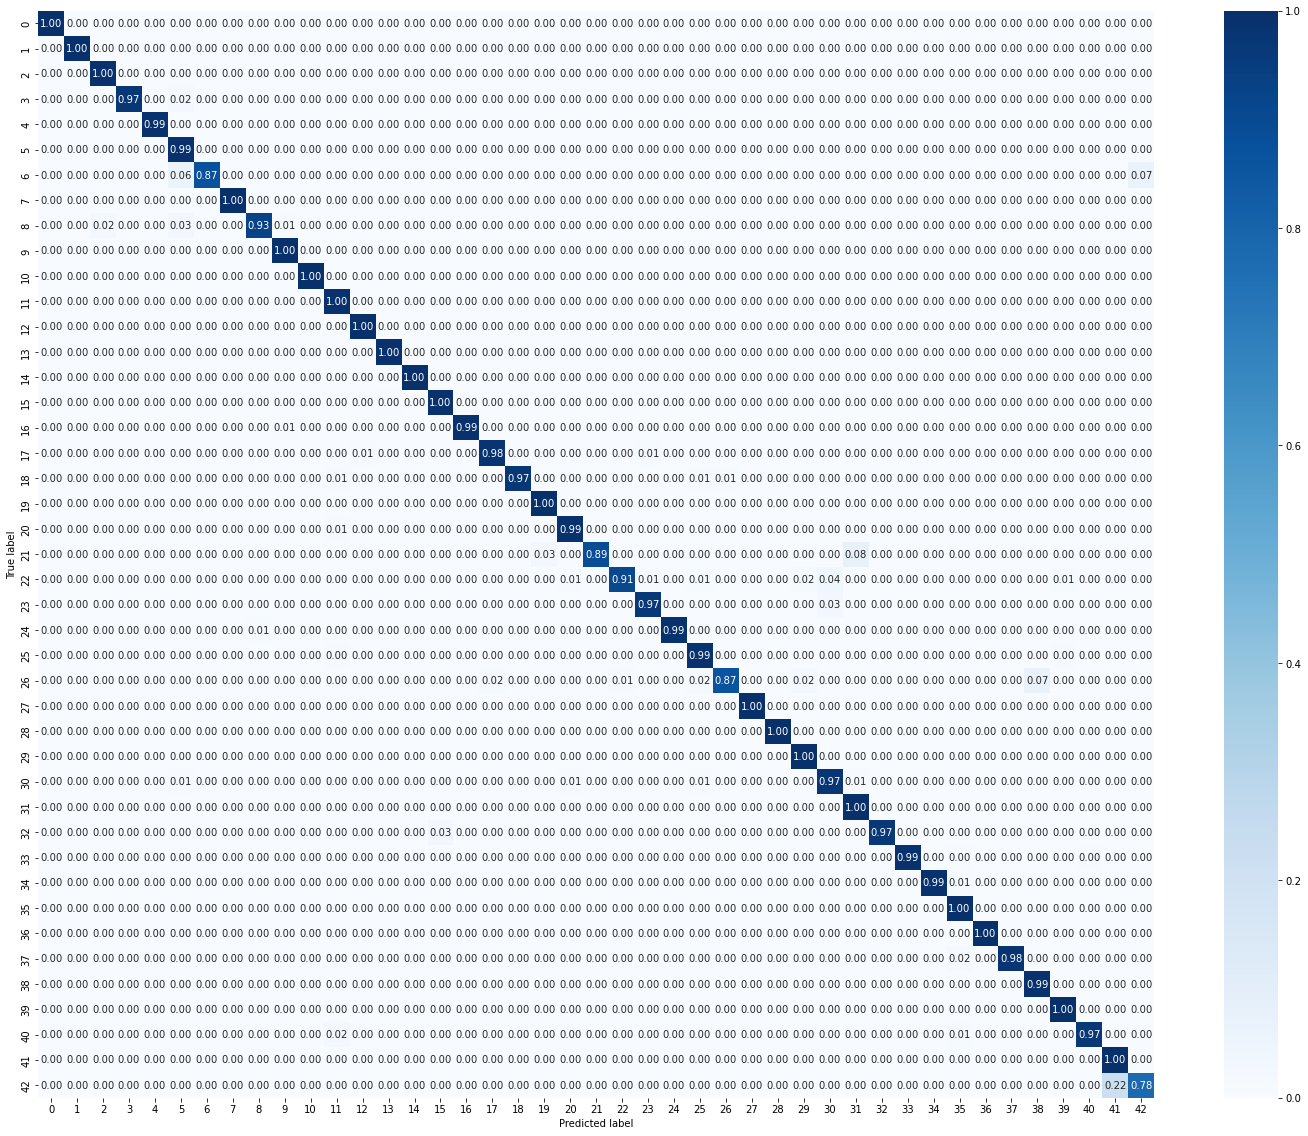

In [14]:
# Provide a class confusion matrix showing relative distribution (in percentages) of
# classifications for each class in each cell (and not cardinalities)

# Plot a confusion matrix
cm = confusion_matrix(gt['ClassId'], pred['ClassId'])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(25,20))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()


In [16]:
cm.shape

(43, 43)

IndexError: index 2 is out of bounds for axis 1 with size 2

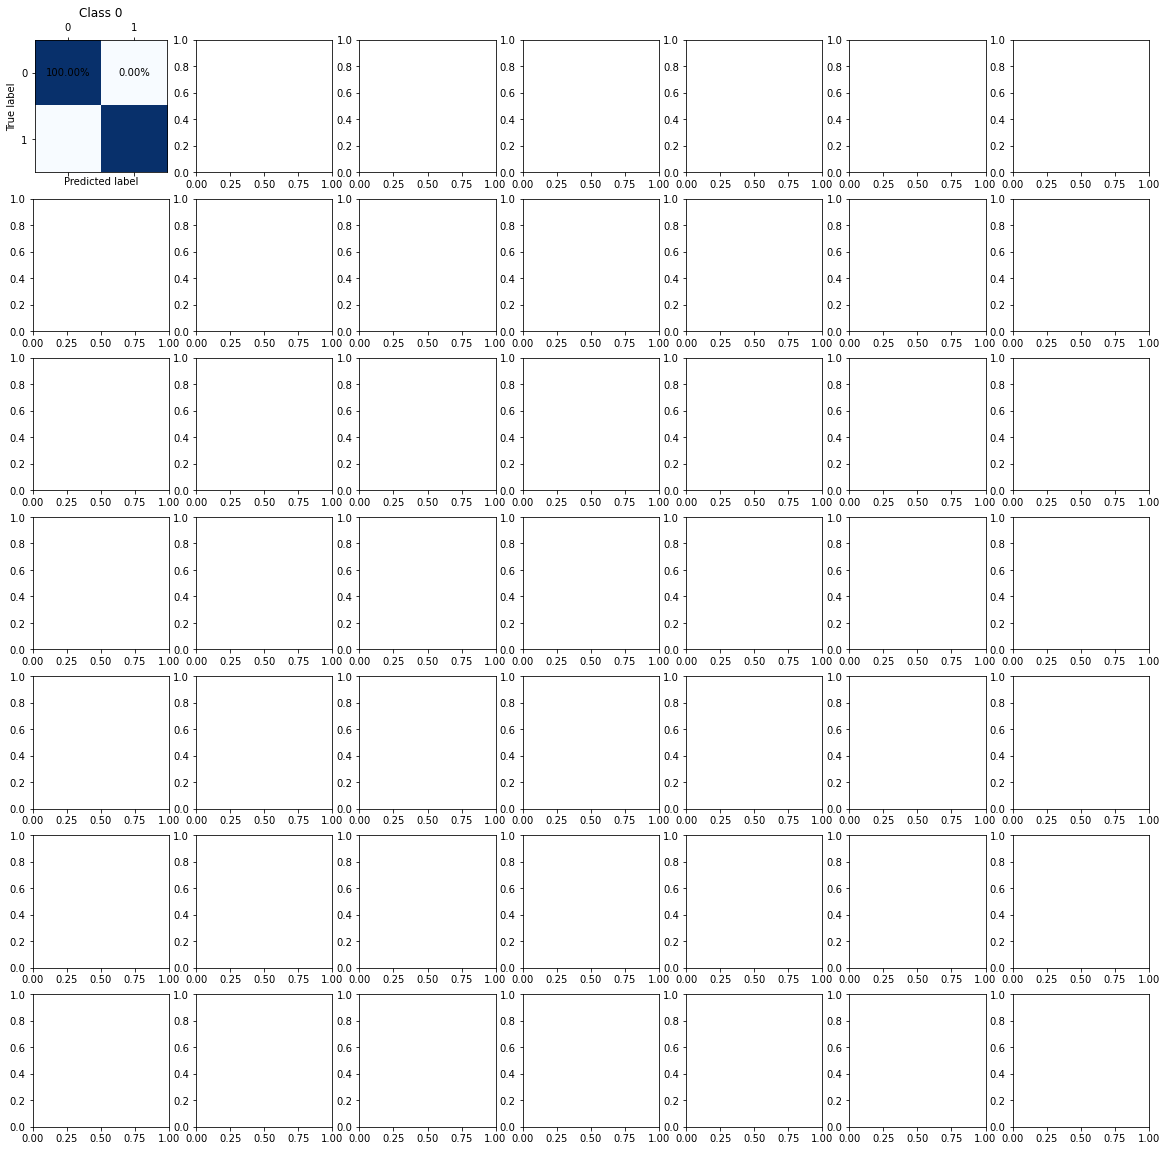

In [8]:
# Create a confusion matrix for each class 
# (i.e. a 43x43 matrix for each class, where each cell is the number of times the class was classified as the row class)
# and plot the average confusion matrix

# Load the ground truth and predicted labels 
true_labels = gt['ClassId'].values
pred_labels = pred['ClassId'].values

# Define the number of classes (assuming 43 in this example)
num_classes = 43

# Generate the confusion matrix for each class
conf_matrices = []
for c in range(num_classes):
    class_true = np.where(true_labels == c, 1, 0)
    class_pred = np.where(pred_labels == c, 1, 0)
    conf_matrix = confusion_matrix(class_true, class_pred)
    conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    conf_matrices.append(conf_matrix_norm)

# Plot the confusion matrix for each class
fig, axes = plt.subplots(nrows=7, ncols=7, figsize=(20,20))
for c in range(num_classes):
    ax = axes[c//7, c%7]
    ax.matshow(conf_matrices[c], cmap='Blues')
    ax.set_title(f'Class {c}')
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    for i in range(num_classes):
        for j in range(num_classes):
            ax.text(j, i, f'{conf_matrices[c][i, j]*100:.2f}%', ha='center', va='center')
plt.tight_layout()
plt.show()
